# Import, Init

In [171]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

In [172]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [173]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

NULLS in data -->  0
>>> train-test inited:  
 	X_train len -->  903 y_train len -->  903 
 	X_test len -->  1342 y_test len -->  1342 
 	NULLS in data -->  0


# Preprocessing

## Keeping Holdout Samples Aside

In [174]:
## SR: MWNUS_CH_PDAY is not refreshed in the source DS => supplies nulls for last week

nn_manager_cut.X_test.drop(columns=[ 'MWNUS_CH_PDAY', 'Open'], inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=[ 'MWNUS_CH_PDAY', 'Open'], inplace=True, errors='ignore')

nn_manager_cut.X_train.columns, nn_manager_cut.X_train.shape

(Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
        'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY', 'Next_day_Price'],
       dtype='object'),
 (903, 11))

In [175]:
hould_out_days = 31
hold_out_X = nn_manager_cut.X_train[-hould_out_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-hould_out_days]

hold_out_y = nn_manager_cut.y_train[-hould_out_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-hould_out_days]

print("X_train, X_test --> ", nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0])
print("Holdout period --> ", hold_out_X.index.min(), "-->", hold_out_X.index.max())

X_train, X_test -->  872 1342
Holdout period -->  2021-05-23 00:00:00 --> 2021-06-22 00:00:00


## Sampling

In [177]:
nn_manager_cut.X_train = nn_manager_cut.X_train.sample(int(100e3), replace=True)

In [178]:
nn_manager_cut.count_nulls_in_data()

NULLS in data -->  0


#### Popping Taret from Train and Test

In [179]:
nn_manager_cut.y_train = nn_manager_cut.X_train.pop("Next_day_Price")
nn_manager_cut.y_test = nn_manager_cut.X_test.pop("Next_day_Price")

hold_out_y = hold_out_X.pop("Next_day_Price")

# Preparing data for model

## Normalizing

In [180]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

# ### tmp ### 
# nn_manager_cut.X_train_normalized = nn_manager_cut.X_train.values 
# nn_manager_cut.X_test_normalized = nn_manager_cut.X_test.values 

(
    nn_manager_cut.X_train_normalized[:2], 
#     nn_manager_cut.X_train_transformed
)

(array([[-0.03101232, -0.03382784,  0.35196678,  0.13912643, -0.51141513,
         -0.84389532, -0.10100137,  0.83908046,  0.13509768,  0.49432325],
        [-1.12538569, -1.24047527,  3.61015974,  0.11658544, -0.38629573,
         -0.63218716, -0.86145373,  0.33333333,  5.44574974, -1.79654935]]),)

## In this scenario we use only sequence =1
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [181]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=1))

self.training_seq_params -->  {'seq_len': 1, 'n_features': 10}
self.X_train_shape -->  [1, 10]
self.X_test_shape -->  [1, 10]


True

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [182]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### DenseNN-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [183]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(1, 10)

In [184]:
nn_manager_cut.X_train.shape

(100000, 10)

In [185]:
# Architecture 

weights_init = GlorotNormal()

template_DNS = [
    Flatten(input_shape=(nn_manager_cut.training_seq_params['n_features'],)),
    Dense(150, 
          activation=LeakyReLU(alpha=0.3),          
          kernel_initializer=weights_init
         ),
    Dense(450, 
          activation=LeakyReLU(alpha=0.3),
          kernel_initializer=weights_init
         ),
    Dense(250, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(50, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(1, kernel_initializer=weights_init)
]

### Compiling Model with the chosen Architecture

In [186]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_DNS, compile_dict=compile_dict)

>>> model compiled
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 150)               1650      
_________________________________________________________________
dense_26 (Dense)             (None, 450)               67950     
_________________________________________________________________
dense_27 (Dense)             (None, 250)               112750    
_________________________________________________________________
dense_28 (Dense)             (None, 50)                12550     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 194,951
Trainable params: 194,951
Non-trainable params: 0
_____________________________

True

## Model Training

#### Model fit

In [191]:
nn_manager_cut.X_train.shape, nn_manager_cut.y_train.shape

((100000, 10), (100000,))

In [194]:
nn_manager_cut.X_train.iloc[:2]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY
393,9569.0,9209.2,765210.0,1.455372e+06,19.645809,1.007421,497970930.0,2025.0,15330.0,340144.0
82,4000.5,3897.9,2860000.0,1.432877e+06,29.200962,1.056968,394595728.0,1475.0,820000.0,227149.0


In [195]:
nn_manager_cut.y_train[:2]

393    9349.1
82     3942.8
Name: Next_day_Price, dtype: float64

In [187]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1, 10], [1, 10])

In [140]:
%%time
res = nn_manager_cut.model.fit(
    x=nn_manager_cut.X_train,
    y=nn_manager_cut.y_train,
    batch_size=32,
    epochs=200,
    verbose=0,
    validation_data=(nn_manager_cut.X_test, nn_manager_cut.y_test),
    shuffle=True,
    workers=3
)

CPU times: user 28min 34s, sys: 4min 22s, total: 32min 57s
Wall time: 8min 9s


last loss:  619.798583984375
last val_loss:  308.4804382324219


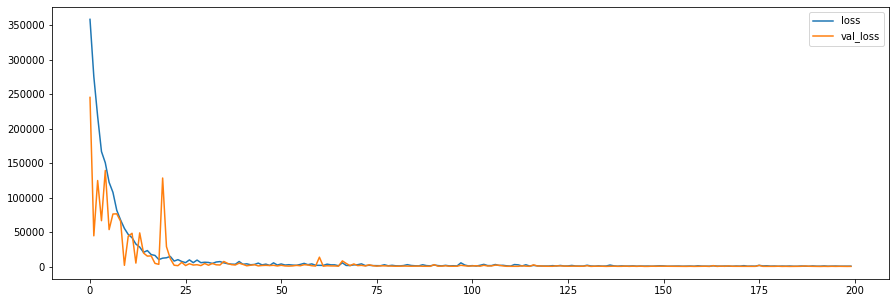

In [141]:
res_df = pd.DataFrame(data=dict(loss=res.history['loss'], val_loss=res.history['val_loss']))
res_df.plot(figsize=(15,5))


print("last loss: ", res_df['loss'].values[-1])
print("last val_loss: ", res_df['val_loss'].values[-1])

In [142]:
nn_manager_cut.model

Architectures: <br>
[[#DenseNN-based]](#DenseNN-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

Train-Test split after swapping data [[go]](#Swapping-(the-trial-issue)) <br>
holdout data [[go]](#Keeping-Holdout-Samples-Aside)

# Saving Model

In [143]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_DNSe_working')

In [144]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

### Plotting 

In [145]:
hold_out_X[:3]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY
Date,,,,,,,,,,
2021-05-23,38248.7,31192.4,325730.0,2.230243e+06,81.406769,1.379972,644175796.0,843.75,139900.0,222357.0
2021-05-24,39851.7,34474.6,244880.0,2.610429e+06,96.801943,1.345943,644370643.0,600.00,-80850.0,194847.0
2021-05-25,39740.8,36540.7,163010.0,2.289845e+06,85.818131,1.359463,644605027.0,787.50,-81870.0,234384.0


In [146]:
hold_out_X_norm = nn_manager_cut.scaler.transform(hold_out_X)

hold_out_X_norm[-1:], hold_out_X_norm.shape[0]

(array([[ 4.62687418,  4.40870958, -0.35261691,  0.63529705, -0.14814591,
          0.79633976,  1.01585442, -0.49418605,  0.38353823, -2.19959743]]),
 31)

In [165]:
left_off_date_index = hold_out_y.index[nn_manager_cut.training_seq_params['seq_len']:]
left_off_date_index

DatetimeIndex(['2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27',
               '2021-05-28', '2021-05-29', '2021-05-30', '2021-05-31',
               '2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
               '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
               '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
               '2021-06-21', '2021-06-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [152]:
hold_out_X_norm[0].shape

(10,)

In [160]:
left_off_pred = [nn_manager_cut.model.predict(seq.reshape(-1, nn_manager_cut.training_seq_params['n_features']))[0][0]
                 for seq in hold_out_X_norm]
left_off_pred[:2]

[20.627104, 23.083088]

In [202]:
## one date test prediction
nn_manager_cut.model_predict(
    nn_manager_cut.scaler
        .transform(hold_out_X.loc['2021-05-24'].values.reshape(1, -1))
        .reshape(-1, nn_manager_cut.training_seq_params['n_features'])
)

array([[0.31390923]], dtype=float32)

In [161]:
hold_out_y.loc['2021-05-24']

38378.3

In [167]:
hold_out_y_df = pd.DataFrame(data=hold_out_y_unrolled, )
hold_out_pred_df = pd.DataFrame(data=left_off_pred, )

In [168]:
hold_out_y[:6]

Date
2021-05-23    38750.6
2021-05-24    38378.3
2021-05-25    39249.2
2021-05-26    38417.3
2021-05-27    35662.5
2021-05-28    34584.6
Name: Next_day_Price, dtype: float64

In [169]:
hold_out_pred_df[:5]

,0
0,20.627104
1,23.083088
2,23.772659
3,24.700371
4,24.026093


<AxesSubplot:>

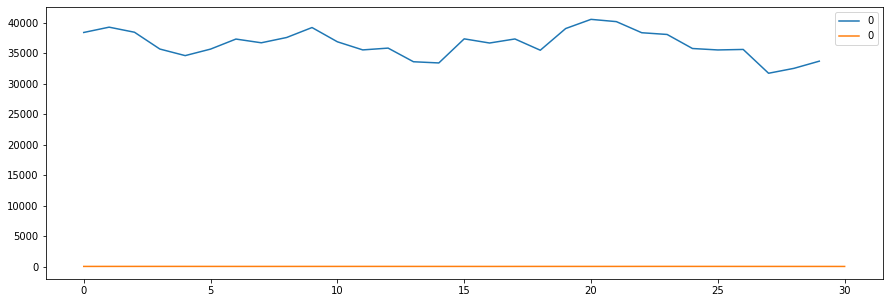

In [170]:
fig, ax = plt.subplots(1, figsize=(15,5))

hold_out_y_df.plot(ax=ax)
hold_out_pred_df.plot(ax=ax)

## think about this tomorrow
https://monosnap.com/file/bLcjLWpyUcocdmuraTyJNIWkKZLhOh

In [ ]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2014-11-01'", "Date<='2014-12-01'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [ ]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [ ]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [ ]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [ ]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [ ]:
# nn_manager_cut.y_test_unrolled[:3]

In [ ]:
# nn_manager_cut.y_pred[:3]

In [ ]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]